# Contrarian Trading

_Fortune befriends the bold_ - Emily Dickinson

Contrarian trading strategies are based on the premise of mean reversion, which posits that asset prices tend to revert to their long-term average over time. This idea is integral to various investment strategies, as it suggests that prices that have deviated significantly from historical norms will eventually return to their equilibrium levels. In these strategies, mispricing can occur due to investor overreaction, leading to temporary opportunities for profitable trades. Common approaches, such as pairs trading and statistical arbitrage, capitalize on these price deviations by simultaneously taking opposing positions in correlated assets. This analysis examines the construction of a contrarian trading strategy, evaluates its performance using key risk-adjusted metrics like the Sharpe ratio, and assesses the effects of implementation shortfall and structural breaks in the strategy's effectiveness over time.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from tqdm import tqdm
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, Benchmarks
from finds.recipes import fractile_split, least_squares
from finds.utils import PyR, row_formatted
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
#%matplotlib qt

importr('strucchange')   # R package to use

rpy2.robjects.packages.Package as a <module 'strucchange'>

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd)

## Mean reversion

The concept of **mean reversion** forms the foundation of many trading strategies. According to the **law of one price**, similar assets should be priced similarly. When this does not hold, traders can exploit the mispricing through **arbitrage** by buying undervalued assets and short-selling overvalued ones, causing the prices to converge. Deviations from expected long-term values, such as yield spreads in fixed income assets, are typically not persistent. **Pairs trading** involves selecting two related securities and trading them to profit from their temporary price divergences. Meanwhile, **statistical arbitrage** (or **stat arb**) relies on complex algorithms to identify and exploit statistical relationships between securities. Although these relationships are not risk-free, stat arb strategies diversify across numerous positions to reduce exposure to risk. However, correlations between asset classes often increase during financial crises due to liquidity constraints and deleveraging, complicating risk management.

We evaluate a **contrarian strategy** based on weekly returns of US stocks, driven by the idea that stock mispricing arises from investor overreaction, as discussed by Lo and Mackinlay (1990). The **alpha** of this strategy can be measured by its **information coefficient** and **volatility** components, as outlined by Grinold (1994). To examine the strategy’s effectiveness over time, we apply tests for **structural breaks** with unknown change points. A key consideration in this analysis is the discrepancy between theoretical portfolio returns, based on assumed execution at decision prices, and actual returns, influenced by factors such as trading costs. The concept of **implementation shortfall** (introduced by Perold in 1988) captures the total cost of executing an investment decision, accounting for both explicit and implicit costs like market impact and opportunity costs.


__Weekly returns reversals__

Daily returns from CRSP are compounded in to weekly stock returns assuming Wednesday-close to Wednesday-close. This skips over weekend and holiday (which often occur over a long weekend) effects. The backtest starts in January 1974, after an expansion of the stocks universe the previous year, and excludes the smallest market cap quintile (based on NYSE breakpoints) comprising microcap stocks.

Let $\overline{r}_{t}$ and $\sigma_{t}$ be the
cross-sectional mean and standard deviation of stock returns in week
$t$. Define $\tilde{r}_t = r_t - \overline{r}_t$ as the vector of
demeaned stock returns, and $X_{t} = -\tilde{r}_t / \sigma_t$ as the
vector of normalized scores. In other words, stocks' "exposures" to (minus) their respective prior week's returns are standardized to have cross-sectional variance and standard deviation equal to 1.0. 

Each week, a portfolio is rebalanced to hold an amount in each stock equal to their respective exposure values divided by the number of holdings $w_{t} = X_{t}/n$.  hence the portfolio overall has unit exposure to prior week's returns $w_{t}^TX_{t} = 1$ and is dollar-neutral $\sum w_{t} = \sum X_{t}/n = 0$. 

This portfolio construction approach can more generally incorporate additional signals where $X$ may be a matrix with ones in the
first column and standardized signal exposures in other columns. Then each row,
except the first, of $W = (X' X)^{-1} X'$ contains stock weights
of a long-short characteristic porfolio: a dollar-neutral,
minimum-norm (in terms of squared weights) portfolio with unit
exposure through long positions in stocks with positive exposure and
short positions in stocks with negative exposure to the signal,
and zero exposure to the other characteristics. 

The portfolio's realized return in the following week $t+1$ is

$$W'_t ~ r_{t+1} = \dfrac{X'_t \tilde{r}_t}{n} + \dfrac{X'_t \hat{r}_t}{n} = -\dfrac{\tilde{r}'_t ~ \tilde{r}_{t+1} ~ \sigma_{t+1}} {n ~ \sigma_{t} ~ \sigma_{t+1}} =
-\rho_{t,t+1} ~ \sigma_{t+1}$$ 

that is the product of the
(negative) cross-sectional correlation of stock returns times the amount of cross-sectional stock volatility at week $t+1$.



In [3]:

weekday = 3          # wednesday close-to-close
bd = BusDay(sql, endweek=weekday)   # Generate weekly cal
begweek = 19740102   # increased stocks coverage in CRSP in Jan 1973
endweek = bd.endwk(CRSP_DATE, -1)
rebaldates = bd.date_range(begweek, endweek, freq='weekly')
retdates = bd.date_tuples(rebaldates)

june_universe = 0  # to track date when reached a June end to update universe
year = 0           # to track new year to pre-load stocks datas in batch by year
results = []
lagged_weights = Series(dtype=float) # to track "turnover" of stock weights
for rebaldate, pastdates, nextdates in tqdm(zip(
        rebaldates[1:-1], retdates[:-1], retdates[1:]), total=len(rebaldates)-1):

    # screen universe each June: largest 5 size deciles
    d = bd.june_universe(rebaldate)
    if d != june_universe:  # need next June's universe
        june_universe = d                        # update universe every June
        univ = crsp.get_universe(june_universe)  # usual CRSP universe screen
        univ = univ[univ['decile'] <= 8]         # drop smallest quintile stocks

    # retrieve new annual batch of daily prices and returns when start new year
    if bd.begyr(rebaldate) != year:
        year = bd.begyr(rebaldate)
        prc = crsp.get_range(dataset='daily',
                             fields=['bidlo', 'askhi', 'prc', 'retx', 'ret'],
                             date_field='date',
                             beg=year,
                             end=bd.offset(bd.endyr(year), 10),
                             cache_mode="rw")

    # get past week's returns, require price at rebalance (decision) date
    past_week = prc[prc.index.get_level_values('date') == rebaldate]['prc']\
        .reset_index()\
        .set_index('permno')\
        .join(crsp.get_ret(*pastdates).reindex(univ.index))\
        .dropna()

    # convert past week's returns to desired standardized portfolio weights
    weights = ((past_week['ret'].mean() - past_week['ret']) /
               (past_week['ret'].std(ddof=0) * len(past_week)))

    # adjust past week's holdings by change stock price
    lagged_weights = lagged_weights.mul(crsp.get_ret(*pastdates, field='retx')\
                                        .reindex(lagged_weights.index)\
                                        .fillna(0) + 1)

    # compute how much to buy (or sell) to achieve desired new portfolio weights
    chg_weights = pd.concat([weights, -lagged_weights], axis=1)\
                    .fillna(0)\
                    .sum(axis=1)

    # calculate total abs weight as denominator for scaling turnover
    total_weight = weights.abs().sum() + lagged_weights.abs().sum()

    # get next week's gross returns
    next_week = crsp.get_ret(*nextdates).reindex(weights.index).fillna(0)

    # get next day's prices to compute one-day slippage cost
    next_day = prc[prc.index.get_level_values('date') ==
                   bd.offset(rebaldate, 1)]\
                   .reset_index()\
                   .set_index('permno')\
                   .drop(columns='date')\
                   .reindex(chg_weights.index)

    # if no trade next day, then enter position at askhi (buy) or bidlo (sell)
    bidask = next_day['askhi'].where(chg_weights > 0, next_day['bidlo']).abs()

    # spread is relevant askhi or bidlo divided by recorded close, minus 1
    spread = next_day['prc'].where(next_day['prc'] > 0, bidask)\
                            .div(next_day['prc'].abs())\
                            .sub(1)\
                            .fillna(0)
    
    # finally, trade_prc is the next day's close, or the relevent askhi or bidlo
    trade_prc = next_day['prc'].where(next_day['prc'] > 0, bidask).fillna(0)

    # drift is next day's trade price with dividends over today's decision price
    # delay (positive is cost) will be chg_weights * drift 
    drift = trade_prc.div(next_day['prc'].abs())\
                     .mul(1 + next_day['ret'])\
                     .sub(1)\
                     .fillna(0)
    

    # exit and enter delay should sum to chg_weights.dot(next_day['ret'])
    exit1 = -lagged_weights.dot(next_day['ret'].reindex(lagged_weights.index).fillna(0))
    enter1 = weights.dot(next_day['ret'].reindex(weights.index).fillna(0))

    # accumulate weekly calculations
    results.append(DataFrame(
        {'ret': weights.dot(next_week),
         'exit1': exit1,
         'enter1': enter1,
         'delay': chg_weights.dot(next_day['ret'].fillna(0)),  # delay=enter+exit
         'spread': chg_weights.dot(spread),
         'slippage': chg_weights.dot(drift), # total slippage
         'ic': weights.corr(next_week),
         'n': len(next_week),
         'beg': nextdates[0],
         'end': nextdates[1],
         'absweight': np.sum(weights.abs()),
         'turnover': chg_weights.abs().sum()/total_weight,
         'vol': next_week.std(ddof=0)},
        index=[rebaldate]))

    # carry forward to next week as lagged portfolio weights
    lagged_weights = weights    


100%|█████████▉| 2659/2660 [01:29<00:00, 29.74it/s]


In [4]:
# Combine accumulated computations and report
df = pd.concat(results, axis=0)
dates = df.index
df.index = pd.DatetimeIndex(df.index.astype(str))
df['net'] = df['ret'].sub(df['slippage'])
# Show summary
cols = ['ic' ,'vol', 'ret', 'slippage', 'net', 'exit1', 'enter1', 'delay',
        'spread', 'turnover']
indexes = ['Information coefficient', 'Cross-sectional Volatility',
           'Gross return (alpha)', 'Slippage cost', 'Net (of slippage) return',
           '   Exit one day delay   ', '   Enter one day delay   ', 'Delay cost',
           'Spread cost', 'Portfolio turnover']

In [5]:
print(f'Summary of Weekly Mean Reversion Strategy {dates[0]}-{dates[-1]}')
pd.concat([df[cols].mean(axis=0).rename('mean'),
           df[cols].std(axis=0).rename('std')], axis=1)\
  .set_index(pd.Index(indexes)).round(4)

Summary of Weekly Mean Reversion Strategy 19740109-20241218


,mean,std
Information coefficient,0.0376,0.1022
Cross-sectional Volatility,0.0536,0.0191
Gross return (alpha),0.0021,0.0080
Slippage cost,0.0017,0.0047
Net (of slippage) return,0.0005,0.0078
Exit one day delay,-0.0003,0.0029
Enter one day delay,0.0006,0.0036
Delay cost,0.0004,0.0041
Spread cost,0.0013,0.0023
Portfolio turnover,0.7363,0.0407


## Implementation shortfall


Perold (1988) observed that the a paper portfolio based upon a
well-known stock rankings system significantly outperformed the actual
track record of funds that make use of the system.  He defined
implementation shortfall as the difference in return between a
theoretical portfolio and the implemented portfolio, which captures explicit
fees and commissions as well as  market impact, delay and
opportunity costs.

- __Decision price__ is the price at the time the investment decision was
  made

- __Arrival price__ is the midquote (mid-point of bid-ask prices) at the
  time the trader, broker or trading system received the order, or the
  trade decision is made.

- __Market drift__ is the amount of buys (sells) multiplied
  by the increase (decrease) in execution price relative to the
  arrival price, due to execution delay.

- __Delay__ is the adverse change in execution price relative to the decision price

- __Opportunity costs__ are the profits lost due to trades that are cancelled or not executed.

-  __Market impact costs__ are bid-ask spreads as well as the amount that buying or selling moves the price against the buyer or seller


The __trader's dilemma__ refers to the trade-off between market drift and
  impact: one can trade faster with more impact to minimize market drift, or
  trade slower to minimize market impact but at the risk of the market drifting
  away.

In practice, stocks in the CRSP database are not available at finer than daily frequency, so we assume that trades are executed at the next day's closing prices. 

If stocks do not trade, we estimate execution prices based on bid-ask spreads. This approach helps address slippage and delays in execution, although transaction costs cannot be directly observed in historical backtests. 

Unfortunately, stock prices in CRSP are not available at a finer than daily frequency. We adjust estimated profits for slippage by waiting a full day after the decision price then setting the execution price at the next day's closing price, when stock market exchanges typically experience the most liquidity at the close of a trading dollar. For stocks that did not trade during that day, we assumed the desired buys are executed at the (higher) ask price and sells are executed at the (lower) bid price (in CRSP for such cases, closing bid and ask quotes are recorded and the closing price is set to the negative of the bid-ask average). This approach helps address slippage and delays in execution, although transaction costs cannot be directly observed in historical backtests. 

Over the full period, much of the profitability of this version of the strategy appears to be dissipated after considering a one-day execution delay and bid-ask spreads.


## Structural break with unknown changepoint

In a linear regression, the Chow test is commonly used to test for the presence of a structural break in the model at a period known _a priori_; it essentially constructs a test of whether the true coefficients on the independent variable split into two subsets are equal. Welch's test that two populations have equal means is a special case with no independent variables and only an intercept whose true values are tested in the two time periods.  However, when the breakpoints are unknown, these standard tests are not applicable. Andrews (1993) and others have developed alternative tests, based on _supremum statistics_, for identifying changes in mean that occur at unknown points in the time series.

The **R library** `strucchange` provides tools for detecting structural breaks, and the **rpy2** Python package facilitates integration with R.  The `PyR` wrapper class in the FinDS package facilitates converting Pandas DataFrames to and from R objects and function calls.

In [6]:
# Structural Break Test with Unknown Changepoint


# Set up data and formulas for R
Y = df['ret']
formula = ro.Formula('y ~ 1')
formula.environment['y'] = PyR(Y.values).ro

# Call R strucchange routines to compute breakpoint statistics
fstats_r = ro.r['Fstats'](formula, **{'from': 1})    # Fstats at every break
breakpoints_r = ro.r['breakpoints'](formula)         # candidate breakpoints
confint_r = ro.r['confint'](breakpoints_r, breaks=1) # conf interval for 1 break
sctest_r = ro.r['sctest'](fstats_r, **{'type': 'aveF'})

# Extract output from R results
confint = PyR(confint_r[0]).frame.iloc[0].astype(int) - 1  # R index starts at 1

output = dict(zip(confint.index, df.index[confint]))       # confidence interval

for k,v in zip(sctest_r.slots['names'][:3], sctest_r[:3]): # significance values
    output[k] = PyR(v).values[0]
output['mean(pre)'] = Y[df.index <= output['breakpoints']].mean() 
output['mean(post)'] = Y[df.index > output['breakpoints']].mean()

fstat = [0] + list(PyR(fstats_r[0]).values) + [0, 0]  # pad before and after

print("Structural break test with unknown changepoint")
DataFrame(output, index=['sctest'])


Structural break test with unknown changepoint


,2.5 %,breakpoints,97.5 %,statistic,p.value,method,mean(pre),mean(post)
sctest,1996-12-04,2001-05-30,2002-11-20,17.588886,0.0,aveF test,0.003112,0.000969


Plot breakpoint F-stats


/tmp/ipykernel_1657351/3930510136.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvspan(df.index[confint[0]], df.index[confint[2]], alpha=0.3, color='grey')


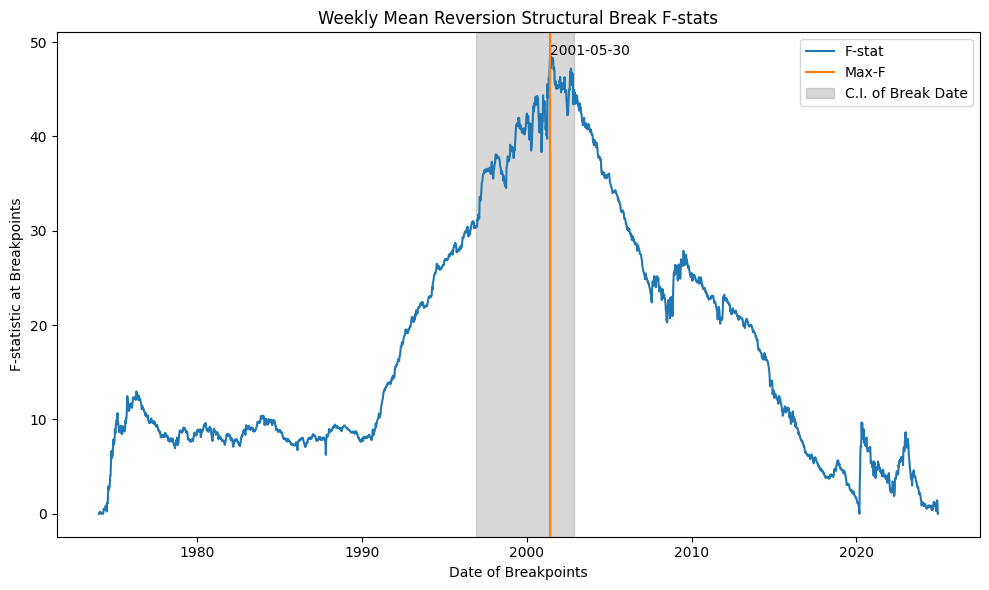

In [7]:
fig, ax = plt.subplots(num=2, clear=True, figsize=(10, 6))
ax.plot(df.index, fstat, color='C0')
argmax = np.nanargmax(fstat)              # where maximum fstat
ax.axvline(df.index[argmax], color='C1')
ax.axvspan(df.index[confint[0]], df.index[confint[2]], alpha=0.3, color='grey')
ax.legend(['F-stat', 'Max-F', 'C.I. of Break Date'])
ax.annotate(
    df.index[argmax].strftime('%Y-%m-%d'), xy=(df.index[argmax], fstat[argmax]))
ax.set_ylabel('F-statistic at Breakpoints')
ax.set_xlabel('Date of Breakpoints')
ax.set_title('Weekly Mean Reversion Structural Break F-stats')
plt.tight_layout()

## Performance evaluation

### Information coefficient

Grinold (1994) linked the expected alpha of a signal to its information coefficient and an asset's signal score and idiosyncratic volatility: $\alpha = IC \times volatility \times score$. 

- __IC__: The information coefficient can be understood as
  the correlation between a signal and residual returns.  It tells how well forecasts align wih actual returns and is a measure of manager forecasting skill.
  
- __Volatility__: The volatility can be understood as an asset's residual risk. This component allows for forecast alpha to be expressed in units of returns.

- __Score__: The score is a standardized measure of an asset's raw
  signal exposure, and reflects relative expectations about an asset.
  Standardization, by subtracing the cross-sectional mean and
  dividing by the cross-sectional standard deviation, allows assets to be
  compared to one another and over time. 

Recall that the weekly reversal portfolio $W_t$ was constructed to be dollar-neutral with exposure equal to 1.0, with weekly profitability $W'_t ~ r_{t+1} = -\rho_{t,t+1} ~ \sigma_{t+1}$.  Hence the **IC** of this strategy can be computed using the negative cross-sectional correlation of stock returns over time. The rolling average of alpha and its components—information coefficient and volatility—reveal trends over the strategy’s life. The data show that while volatility fluctuated over time, the **IC** sharply declined after reaching a peak in the mid-1990s, continuing its downward trajectory through 2010.

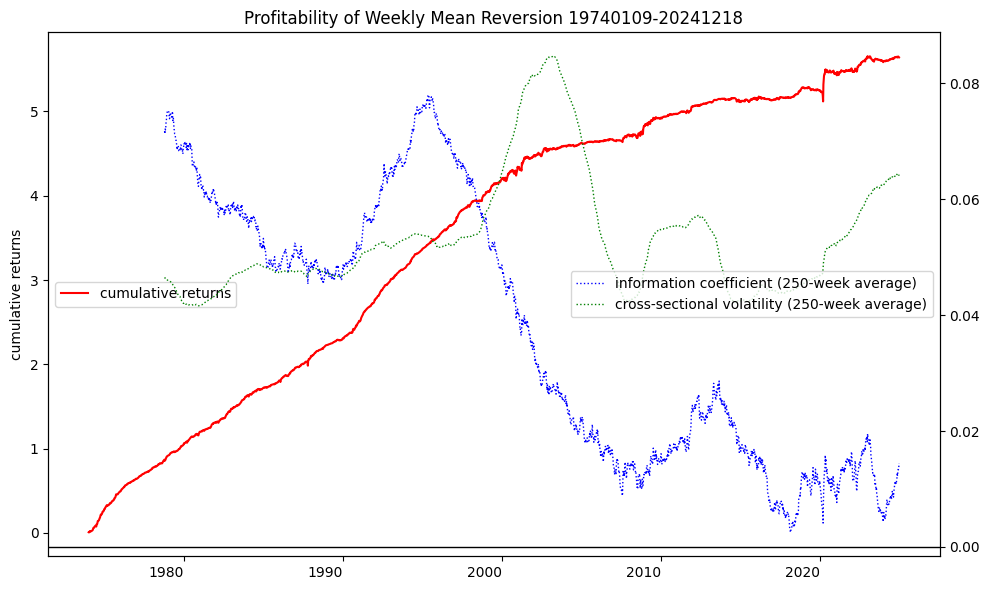

In [8]:
## Plot returns, and rolling avg information coefficient and cross-sectional vol
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
df['ret'].cumsum().plot(ax=ax, ls='-', color='r', rot=0)
ax.legend(['cumulative returns'], loc='center left')
ax.set_ylabel('cumulative returns')
bx = ax.twinx()
roll = 250  # 250 week rolling average ~ 5 years
df['ic'].rolling(roll).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='b')
df['vol'].rolling(roll).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='g')
#bx.axhline(df['ic'].mean(), linestyle='-', color='C0', lw=2)
bx.axhline(0, linestyle='-', color='black', lw=1)
bx.legend([f"information coefficient ({roll}-week average)",
           f"cross-sectional volatility ({roll}-week average)"],
          loc='center right')
ax.set_title(f'Profitability of Weekly Mean Reversion {dates[0]}-{dates[-1]}')
plt.tight_layout()

### Risk-adjusted performance measures

In a CAPM equilibrium, no investor can achieve an abnormal return, and each investment yields an identical risk-adjusted return. In the real world, assets may yield a return in excess of, or below, that which fairly compensates for their risk exposure.  To assess the strategy's risk-adjusted performance, we employ several key metrics:
                                                        
- Sharpe ratio - slope of the capital market line is the fair equilibrium compensation: $\dfrac{R_P - r_f}{\sigma_P}$
- Treynor ratio - uses beta which is an approriate measure of risk for a well-diversified portfolio:  $\dfrac{R_P - r_f}{\beta_P}$
- Jensen's alpha - the intercept of a CAPM regression should be zero in equilibrium:  $R_P - r_f- \beta_P(R_M - r_f)$
- Appraisal ratio - Jensen's alpha scaled by the volatility of residual returns $\dfrac{\alpha}{\sigma_{P-M}}$
- Sortino ratio - focuses on downside risk relative a target required rate of return T: $\dfrac{R_P - T}{\sqrt{\sum_t \min(0, r_t - T)^2 / N}}$
- Information ratio - adjusts performance relative to a benchmark, called the acive return, scaled by the volatility of active returns, called tracking error: $\dfrac{\hat{R_P} - \hat{R_B}}{\sigma_{R_P-R_B}}$
- $M^2$ (Modigliani-squared) - imagines that the given portfolio, P, is mixed with a position in T-bills so that the resulting portfolio P* matches the volatility of the market portfolio. Because the market index and portfolio $P^*$ have the same standard deviation, their performance may be compared by simply subtracting returns: $R_{P^*} - R_M$ 




In [9]:
market = bench.get_series(permnos=['Mkt-RF'], field='ret').reset_index()
breakpoint = BusDay.to_date(output['breakpoints'])
out = dict()
for select, period in zip([dates > 0, dates <= breakpoint, dates > breakpoint],
                          ['Full', 'Pre-break', 'Post-break']):
    res = df[select].copy()
    res.index = dates[select]

    # align market returns and compute market regression beta
    #res['date'] = res.index
    res['mkt'] = [(1 + market[market['date'].between(*dt)]['Mkt-RF']).prod() - 1
                  for dt in res[['beg','end']].itertuples(index=False)]
    # model = lm(res['mkt'], res['ret'], flatten=True)
    model = least_squares(data=res, y=['ret'], x=['mkt'], stdres=True)

    # save df summary
    out[f"{period} Period"] = {
        'start date': min(res.index),
        'end date': max(res.index),
        'Sharpe Ratio': np.sqrt(52)*res['ret'].mean()/res['ret'].std(),
        'Average Gross Return': res['ret'].mean(),
        'Std Dev Returns': res['ret'].std(),
        'Market Beta': model.iloc[1],
        'Jensen Alpha (annualized)': model.iloc[0] * 52,
        'Appraisal Ratio': np.sqrt(52) * model.iloc[0] / model.iloc[2],
        'Information Coefficient': res['ic'].mean(),
        'Cross-sectional Vol': res['vol'].mean(),
        'Total Slippage Cost': res['slippage'].mean(),
        'Spread Cost': res['spread'].mean(),
        'Delay Cost': res['delay'].mean(),
        '  Exit Delay Cost': res['exit1'].mean(),
        '  Enter Delay Cost': res['enter1'].mean(),
        'Average Net Return': res['net'].mean(),
        'Portfolio Turnover': res['turnover'].mean(),
        #'Abs Weight': res['absweight'].mean(),
        'Average Num Stocks': int(res['n'].mean()),
    }

In [10]:
# Display as formatted DataFrame
fmts = dict.fromkeys(['start date', 'end date', 'Average Num Stocks'], '{:.0f}')
print("Subperiod Performance of Weekly Reversals")
row_formatted(DataFrame(out), formats=fmts, default='{:.4f}')

Subperiod Performance of Weekly Reversals


,Full Period,Pre-break Period,Post-break Period
start date,19740109,19740109,20010606
end date,20241218,20010530,20241218
Sharpe Ratio,1.9185,3.6668,0.7300
Average Gross Return,0.0021,0.0031,0.0010
Std Dev Returns,0.0080,0.0061,0.0096
Market Beta,0.0898,0.0686,0.1109
Jensen Alpha (annualized),0.1030,0.1566,0.0407
Appraisal Ratio,1.8537,3.6607,0.6140
Information Coefficient,0.0376,0.0578,0.0140
Cross-sectional Vol,0.0536,0.0542,0.0529


The structural break test identified a statistically significant change in the strategy’s weekly returns around mid-2001. Comparing performance before and after this point reveals a clear decline in the annualized Sharpe ratio and average weekly returns, along with an increase in risk. This shift roughly coincides with the adoption of decimalization by the New York and American Stock Exchanges on January 29, 2001, which resulted in tighter bid-ask spreads. Prior to this change, U.S. markets quoted prices in fractions, with one-sixteenth (1/16) of a dollar being the smallest allowable price increment.



**`R`** usage notes:

```
/usr/bin/ld: cannot find -lgfortran
collect2: error: ld returned 1 exit status
```
- check versions are the same: `gfortran --version` and `gcc --version`
- select versions to be the same: `sudo update-alternatives --config gcc`

**__References__:**


Andrews, D.W.K., "Tests for parameter instability and structural change with unknown change point", Econometrica, 61 (1993), 821-856.

Grinold, Richard C., 1994, "Alpha is Volatility Times IC Times Score", The Journal of Portfolio Management, Summer 1994, 20(4), 9-16

Lo, Andrew W. and MacKinlay, A. Craig, 1990, "When Are Contrarian Profits Due to Stock Market Overreaction?", The Review of Financial Studies, 3(2), 175–205

Perold, Andre, 1988, "The Implementation Shortfall: Paper versus Reality", The Journal of Portfolio Management, 14(3), 4-9